In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.cross_validation import cross_val_score
import matplotlib
from matplotlib import pyplot as plt  
from matplotlib import rc
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sb
from pylab import rcParams

## Visualizations and Data and Model Exploration 

In [2]:
data = pd.read_pickle("clean_nyt_training_data.pkl")

label_dict = {0: "Arts", 1: "Business", 2: "Food", 3: "Health", 4: "NY", 5: "Politics", 6: "RealEstate", 7: "Science", \
             8: "Sports", 9: "Style", 10: "Tech", 11: "Travel", 12: "US", 13: "World"}

### 1. Absolute number of samples

In [3]:
len(data)

115327

#### We have 115.327 article samples

### 2. Number of samples per category

In [4]:
data["category"] = data["label"].apply(lambda x: label_dict[x])

In [5]:
plot1data = data["label"].value_counts()
plot1frame = pd.DataFrame(plot1data)
plot1frame.rename(columns={0: 'Counts'}, inplace=True)
plot1frame = plot1frame.reset_index()
plot1frame.rename(columns={'index': 'label'}, inplace=True)
plot1frame["category"] = plot1frame["label"].apply(lambda x: label_dict[x])

In [6]:
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14) 
rcParams['figure.figsize'] = 13, 10

(0, 10500)

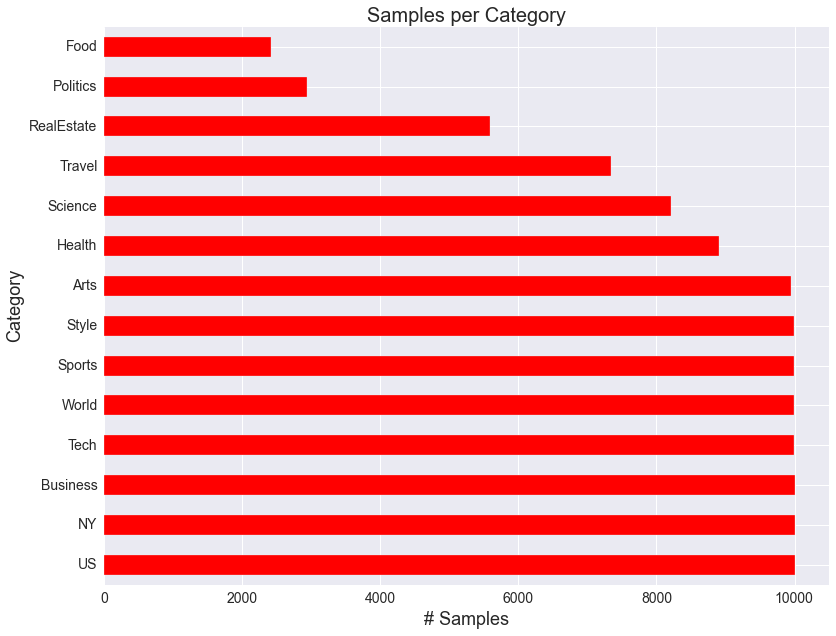

In [7]:
plot1frame.plot(x="category", y="Counts", kind='barh', rot=0, color="r")
plt.title('Samples per Category', fontsize=20)
plt.ylabel('Category', fontsize=18)
plt.xlabel('# Samples', fontsize=18)
ax = plt.gca()
ax.legend_ = None
ax.set_xlim([0, 10500])

### 3. Histogram with wordnumbers, stacked per label

In [8]:
plot2frame = pd.DataFrame()
for key, value in label_dict.iteritems():
    plot2frame[value] = data[data["label"]==key]["length"].value_counts()
plot2frame = plot2frame.sort_index()

(0, 150)

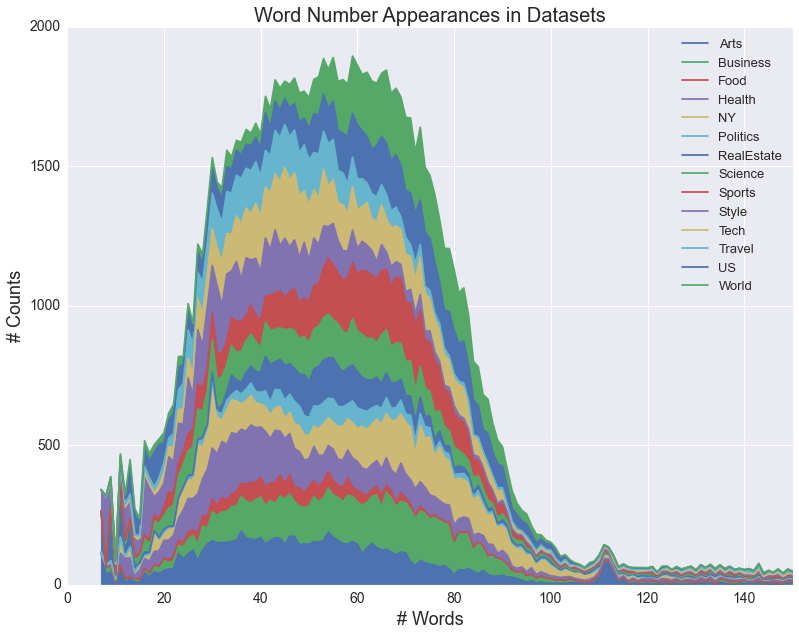

In [9]:
plot2frame.plot(kind='area')
plt.title('Word Number Appearances in Datasets', fontsize=20)
plt.ylabel('# Counts', fontsize=18)
plt.xlabel('# Words', fontsize=18)
ax = plt.gca()
ax.legend(fontsize=13)
ax.set_xlim([0, 150])

### 4. The Logistic Regression Model - Coefficients

In [10]:
model = pickle.load(open("log_regression_model.pkl"))

In [11]:
tfidf = pickle.load(open("tfidf_vectorizer.pkl"))

In [12]:
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18) 

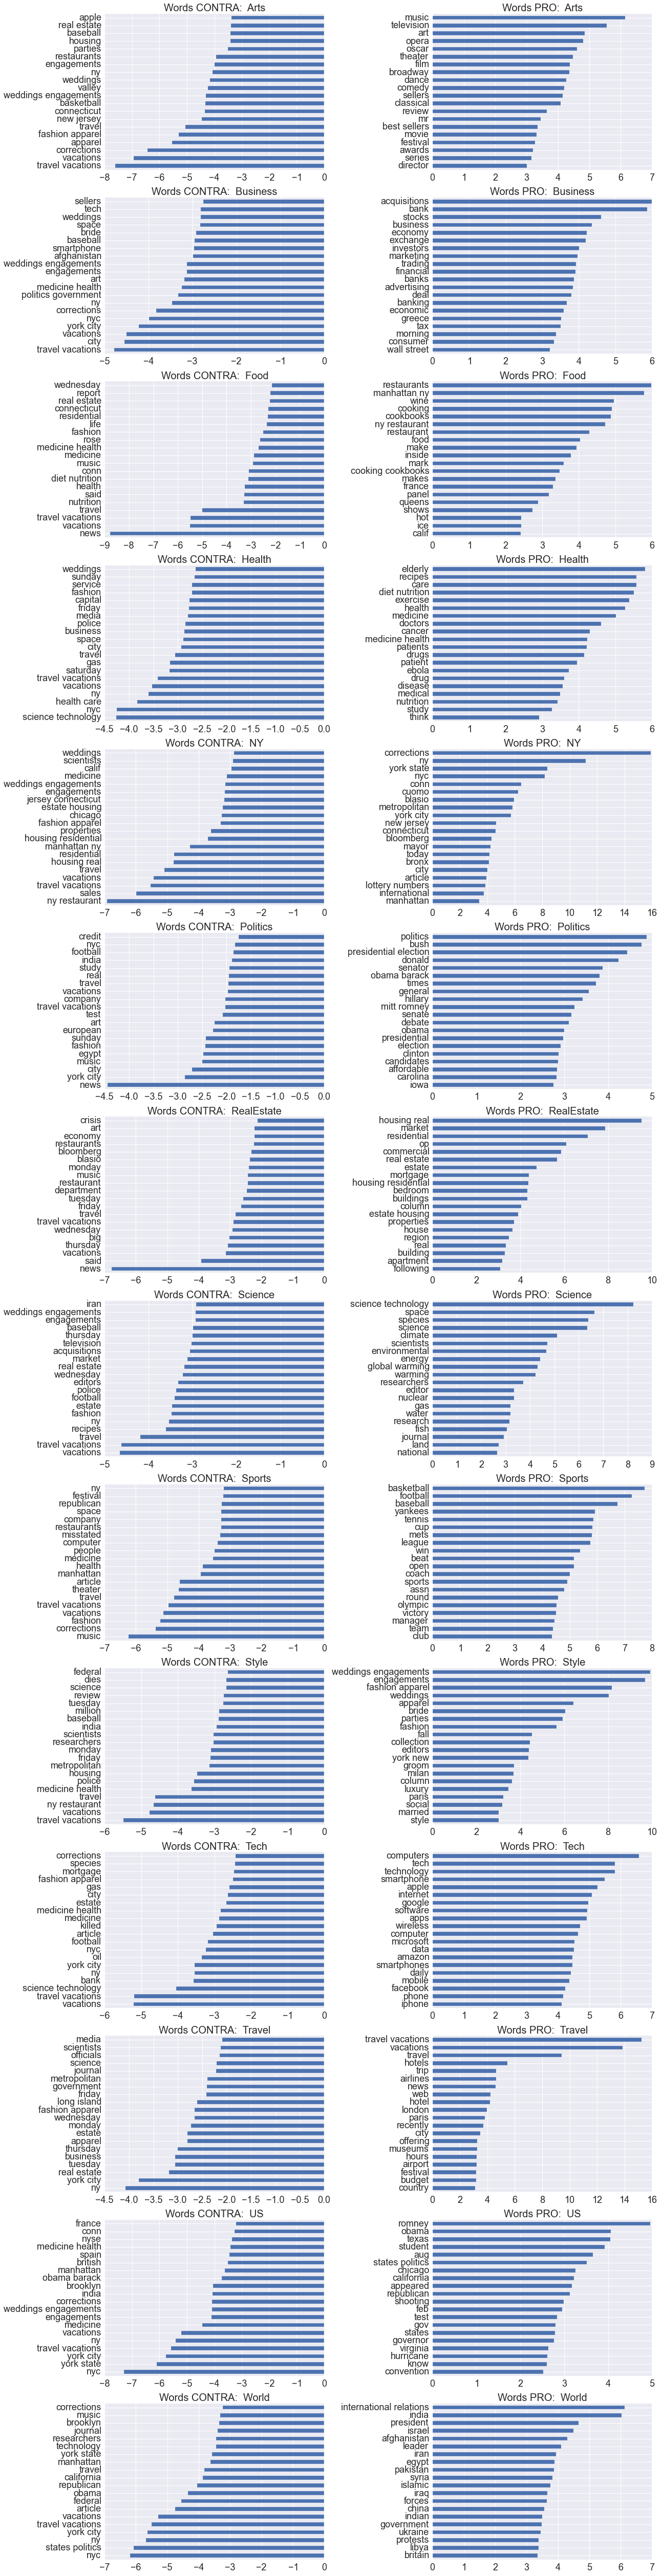

In [13]:
fig, axes = plt.subplots(14, 2, figsize=(18,70))
for key, value in label_dict.iteritems():
    coef = pd.Series(model.coef_[key], index=tfidf.get_feature_names())
    coef.sort()   
    coef[:20].plot(kind='barh', ax=axes[key,0])
    coef[-20:].plot(kind='barh', ax=axes[key,1])
    f = axes[key, 0].set_title("Words CONTRA:  " + value, fontsize = 20)
    f = axes[key, 1].set_title("Words PRO:  " + value, fontsize = 20)
f = plt.tight_layout()

### 5. The Logistic Regression Model - Scores

In [14]:
X, y = tfidf.fit_transform(data.allwords).todense(), data.label

In [15]:
cross_val_score(model, X, y, cv=4, scoring='accuracy').mean()

0.75027534287492947

In [16]:
-cross_val_score(model, X, y, cv=4, scoring='log_loss').mean()

0.83577133552156435

### Let's compare these to the naive baselines. Naive baselines are:

## Accuracy

Just predict randomly, hence 1/14 = 0.07 chance to hit correctly. 

#### **Therefore, accuracy naive baseline: 0.07**

## Logloss

Multi Class Log Loss is defined as

$$logloss = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{i,j} \log(p_{i,j})$$

for N samples and M different classes.

So, assume we just predict randomly. Then $p_{i,j} = 0.07$ and $\log(p_{i,j}) = -2.64$ for all i and j. 

$y_{i,j}$ is one whenever it's real label for sample i does not correspond to the index j. In these cases we use $\log(p_{i,j})$ as penalty in the logloss. Hence, in our situation it is in 13 out of 14 cases one. Otherwise, it's zero. Then we sum over all samples but normalize with the total number of samples. Hence, the logloss for random prediction would be -13 * -2.64 = 34.30 

#### **Therefore, logloss naive baseline: 34.30**

## Our Scores

Seems like we are doing not too bad. Predicting correctly in about 75% of all cases seems good when having 14 different labels. Similarly, a logloss of 0.836 also seems quite good compared to the baseline.